## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.models.interpretable import LFCNN
from deepmeg.interpreters import LFCNNInterpreter
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp
from deepmeg.viz import generate_cmap

ModuleNotFoundError: No module named 'deepmeg.viz'

## Reading Epochs and preprocessing

In [2]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs.apply_baseline((None, 0))
epochs.resample(600).crop(0, None)
info = epochs.info

## Create a dataset containig epoched data

In [2]:
# dataset = EpochsDataset(epochs, savepath='../dataset', transform = zscore)
dataset = EpochsDataset.load('../data/simulated_n2.pt')
# dataset = EpochsDataset.load('../data/multimodal.pt')
# del raw, epochs, epochs_list
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [3]:
from mne.datasets import sample
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_raw = meg_path / 'sample_audvis_raw.fif'

info = mne.io.read_raw_fif(fname_raw).resample(200).pick_types(meg='grad').info

In [5]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [4]:
X, y = next(iter(DataLoader(test, len(test))))
X.shape
y.shape

torch.Size([86, 2])

## Compile the model

In [6]:
model = LFCNN(
    n_channels=X.shape[1], # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=X.shape[-1], # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=y.shape[1] # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

## Training the model

Epoch 0:  loss_train:  0.7147   |    binary_accuracy_train:  0.5545   |    loss_val:  0.7286   |    binary_accuracy_val:  0.4891
  1%|          | 1/150 [00:00<01:08,  2.18it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 1:  loss_train:  0.7021   |    binary_accuracy_train:  0.6122   |    loss_val:  0.7204   |    binary_accuracy_val:  0.5435
Epoch 2:  loss_train:  0.6889   |    binary_accuracy_train:  0.6891   |    loss_val:  0.7111   |    binary_accuracy_val:  0.5870
Epoch 3:  loss_train:  0.6746   |    binary_accuracy_train:  0.7404   |    loss_val:  0.7002   |    binary_accuracy_val:  0.6304
Epoch 4:  loss_train:  0.6590   |    binary_accuracy_train:  0.7885   |    loss_val:  0.6875   |    binary_accuracy_val:  0.7065
Epoch 5:  loss_train:  0.6417   |    binary_accuracy_train:  0.8622   |    loss_val:  0.6726   |    binary_accuracy_val:  0.7717
Epoch 6:  loss_train:  0.6227   |    binary_accuracy_train:  0.8846   |    loss_val:  0.6555   |    binary_accuracy_val:  0.7935
Epoch 7:  loss_train:  0.6016   |    binary_accuracy_train:  0.9295   |    loss_val:  0.6358   |    binary_accuracy_val:  0.8587
Epoch 8:  loss_train:  0.5784   |    binary_accuracy_train:  0.9551   |    loss_val:  0.6136   | 

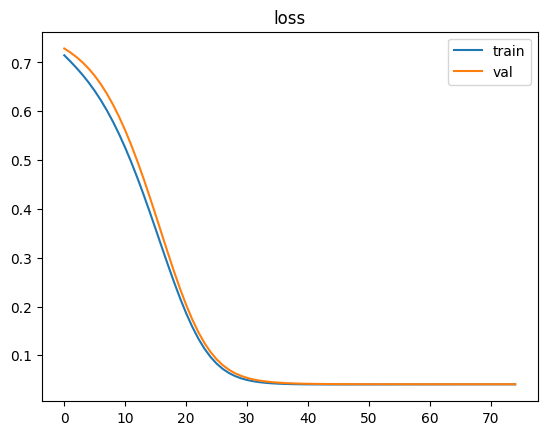

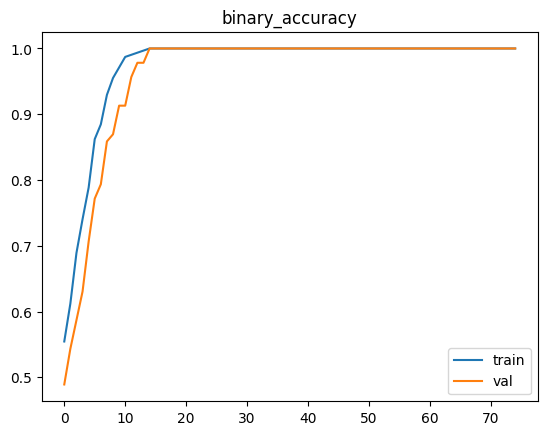

In [7]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [9]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.04051141779531132
train_binary_accuracy: 1.0
loss: 0.0406627089462497
binary_accuracy: 1.0


In [11]:
w = model.unmixing_layer.weight.detach().numpy()

In [12]:
w.shape

(8, 203, 1)

In [18]:
w_ = w[1, :]

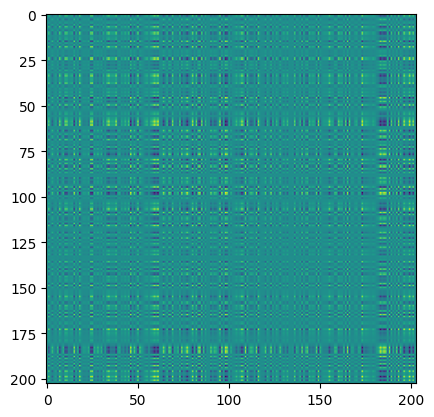

In [23]:
plt.imshow(w_@w_.T)

## Model interpretation

In [38]:
interpreter = LFCNNInterpreter(model, test, info)

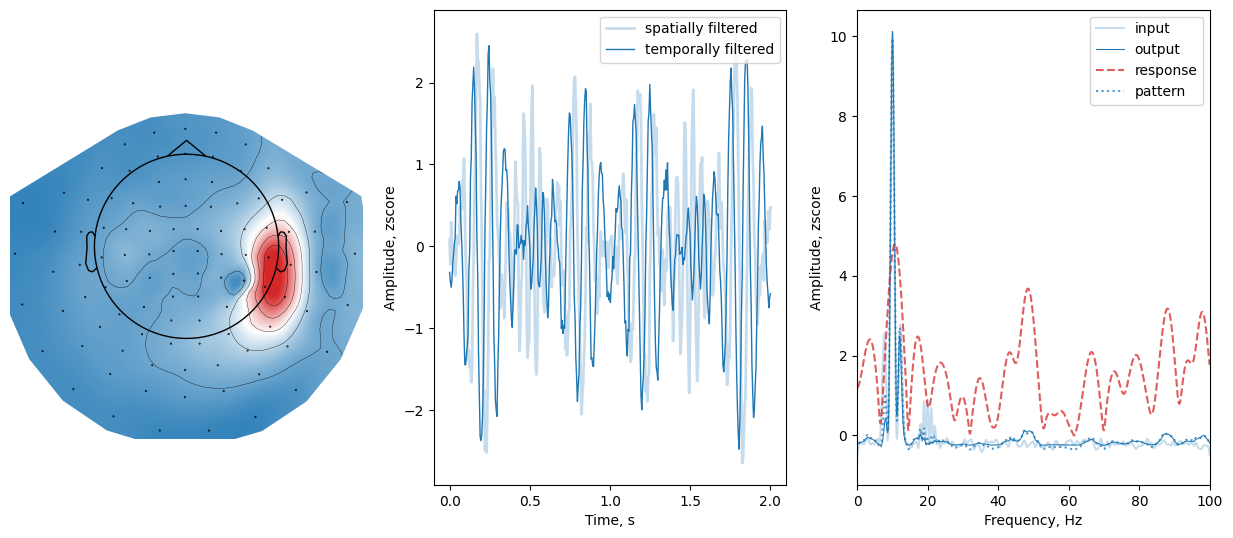

In [40]:
%matplotlib inline

fig = interpreter.plot_branch(0, ['input', 'output', 'response', 'pattern'])

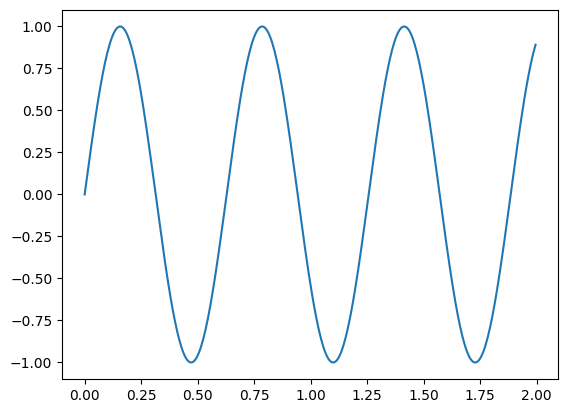

In [173]:
%matplotlib inline
sfreq = 200

t = np.arange(0, 2, 1/sfreq)
sig = np.sin(10*t)
freqs = np.arange(1, sfreq//2)

plt.plot(t, sig)

In [12]:
sig = interpreter.latent_sources.mean(0)[0]

plt.plot(sig)

In [58]:
interpreter.info['sfreq']

200.0

In [41]:
import scipy.signal as sl


def compute_morlet_cwt(
    sig: np.ndarray,
    sfreq: float,
    omega_0: float = 5,
    phase: bool = False
) -> np.ndarray:
    """
    Computes the continuous wavelet transform (CWT) of a signal using a Morlet wavelet.

    Args:
        sig (numpy.ndarray): Input signal to be transformed.
        sfreq (float): Sampling frequency of the input signal.
        omega_0 (float, optional): Center frequency of the wavelet. Defaults to 5.
        phase (bool, optional): Flag to control the return type of the transformed data.
                                If `True`, only the phase angle will be returned.
                                Otherwise, the magnitude squared will be returned. Defaults to False.

    Returns:
        numpy.ndarray: Transformed data of the input signal with a Morlet wavelet.
                        If `phase` is `True`, the function returns a complex array of the same shape as `sig`.
                        Otherwise, it returns a real array of the same shape as `sig`.
    """
    dt = 1/sfreq
    freqs = np.arange(1, sfreq//2)
    widths = omega_0 / ( 2*np.pi * freqs * dt)
    cwtmatr = sl.cwt(sig, lambda M, s: sl.morlet2(M, s, w=omega_0), widths)
    if phase:
        return cwtmatr
    else:
        return np.real(cwtmatr)**2 + np.imag(cwtmatr)**2


def compute_induceds(interpreter: LFCNNInterpreter) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes induced activity of latent sources.

    Args:
        interpreter (LFCNNInterpreter): Instance of the LFCNNInterpreter class.

    Returns:
        tuple: A tuple of two numpy arrays, each with shape (n_sources, n_frequencies, n_times), containing the
        induced activity for the original (unfiltered) and the filtered latent sources.
    """
    time_courses = np.transpose(interpreter.latent_sources, (1, 0, 2))
    time_courses_filtered = np.transpose(interpreter.latent_sources_filtered, (1, 0, 2))
    induceds = list()
    induceds_filt = list()

    for tc, tc_filt in zip(time_courses, time_courses_filtered):
        ls_induceds = list()
        ls_induceds_filt = list()

        for lc, lc_filt in zip(tc, tc_filt):
            ls_induceds.append(np.abs(compute_morlet_cwt(lc, interpreter.info['sfreq'], 15)))#, 7.5)))
            ls_induceds_filt.append(np.abs(compute_morlet_cwt(lc_filt, interpreter.info['sfreq'], 15)))#, 7.5)))

        induceds.append(np.array(ls_induceds).mean(axis=0))
        induceds_filt.append(np.array(ls_induceds_filt).mean(axis=0))

    return np.array(induceds), np.array(induceds_filt)

In [61]:
from collections import namedtuple
import pickle
from abc import ABC, abstractmethod
from typing import Any

SpatialParameters = namedtuple('SpatialParameters', 'patterns filters')
SpectralParameters = namedtuple('SpectralParameters', 'range inputs outputs responses patterns')
TemporalParameters = namedtuple('TemporalParameters', 'times time_courses time_courses_filtered induceds induceds_filtered patterns', defaults=[None])
Predictions = namedtuple('Predictions', 'y_p y_true')

def save(content: Any, path: str | os.PathLike):
    """
    Save an object using pickle serialization.

    Args:
    content (Any): the object to be serialized and saved.
    path (str | os.PathLike): the path and filename where the serialized object will be saved.
    The file extension must be '.pkl'.

    Raises:
    OSError: if the file extension of path is not '.pkl'.

    Returns:
    None
    """

    if path[-4:] != '.pkl':
        raise OSError(f'Pickle file must have extension ".pkl", but it has "{path[-4:]}"')

    pickle.dump(content, open(path, 'wb'))


def read_pkl(path: str | os.PathLike) -> Any:
    """
    Read a pickled object from a file.

    Args:
    path (str or os.PathLike): Path to the pickled file to be read.

    Returns:
    Any: The content of the pickled file.

    Raises:
    FileNotFoundError: If the file specified by the path does not exist.
    OSError: If the file specified by the path is not a valid pickle file.
    """
    with open(
        path,
        'rb'
    ) as file:
        content = pickle.load(
            file
        )
    return content

class NetworkParameters(ABC):
    """The NetworkParameters class is an abstract base class that defines the basic interface for neural network parameter objects. It includes abstract properties for the spatial, spectral, and temporal parameters of the network, as well as properties for the order and additional information. The class also provides methods for saving the object to a pickle file and for reading a pickle file.

    Attributes:

        None

    Methods:

        save(path: str | os.PathLike) -> None: Saves the object to a pickle file.
        read_pkl(path: str | os.PathLike) -> 'NetworkParameters': Reads a pickle file and returns the contents as a new NetworkParameters object.

    Abstract Properties:

        spatial: An abstract property that returns a SpatialParameters object containing spatial filter and pattern information.
        spectral: An abstract property that returns a SpectralParameters object containing spectral input, output, and response information.
        temporal: An abstract property that returns a TemporalParameters object containing temporal information such as times, time courses, and induced activity.
        order: An abstract property that returns a string indicating the order of the model.
        info: An abstract property that returns a dictionary containing additional information about the model.
    """
    @property
    @abstractmethod
    def spatial(self):
        ...
    @property
    @abstractmethod
    def spectral(self):
        ...
    @property
    @abstractmethod
    def temporal(self):
        ...

    @property
    @abstractmethod
    def order(self):
        ...

    @property
    @abstractmethod
    def info(self):
        ...

    def save(self, path: str | os.PathLike):
        """
        Save an NetworkParameters object using pickle serialization.

        Args:
        path (str | os.PathLike): the path and filename where the serialized object will be saved.
        The file extension must be '.pkl'.

        Raises:
        OSError: if the file extension of path is not '.pkl'.

        Returns:
        None
    """
        save(self, path)

    @staticmethod
    def read_pkl(path: str | os.PathLike) -> 'NetworkParameters':
        """
        Read a pickled NetworkParameters object from a file.

        Args:
        path (str or os.PathLike): Path to the pickled file to be read.

        Returns:
        NetworkParameters: The content of the pickled file.

        Raises:
        FileNotFoundError: If the file specified by the path does not exist.
        OSError: If the file specified by the path is not a valid pickle file.
        """
        return read_pkl(path)


class LFCNNParameters(NetworkParameters):
    """A class representing the parameters required for a neural network.

    This class is designed to provide the parameters necessary for a specific neural network. The `LFCNNParameters` class
    takes a `LFCNNInterpreter` object, which is used to generate the spatial, spectral, and temporal parameters needed
    for the network.

    Attributes:
        spatial (SpatialParameters): A named tuple that contains the spatial patterns and filters.
        spectral (SpectralParameters): A named tuple that contains the frequency range, filter inputs, outputs,
            responses and patterns.
        temporal (TemporalParameters): A named tuple that contains the times, time courses, time courses filtered,
            induceds, induceds filtered and patterns.
        info (dict): A dictionary containing information about the data used in the network.
        order (int): An integer representing the order of the loss function used by the network.

    Methods:
        save(path: str | os.PathLike): Saves the `LFCNNParameters` object to a .pkl file.
        read_pkl(path: str | os.PathLike) -> 'LFCNNParameters': Loads the `LFCNNParameters` object from a .pkl file.
    """
    def __init__(self, interpreter: LFCNNInterpreter):
        """Initializes the `LFCNNParameters` object.

        Args:
            interpreter (LFCNNInterpreter): An `LFCNNInterpreter` object that is used to generate the required parameters.
        """
        self._info = interpreter.info
        self._spatial = SpatialParameters(interpreter.spatial_patterns, interpreter.spatial_filters)
        self._spectral = SpectralParameters(
            interpreter.frequency_range,
            interpreter.filter_inputs,
            interpreter.filter_outputs,
            interpreter.filter_responses,
            interpreter.filter_patterns
        )
        times = np.arange(0, interpreter.latent_sources.shape[-1]/interpreter.info['sfreq'], 1/interpreter.info['sfreq'])
        spectrums, spectrums_filtered = compute_induceds(interpreter)
        self._temporal = TemporalParameters(
            times,
            interpreter.latent_sources,
            interpreter.latent_sources_filtered,
            spectrums, spectrums_filtered
        )
        self._order = interpreter.branchwise_loss

    @property
    def spatial(self):
        """A property getter method that returns the `SpatialParameters` attribute of the `LFCNNParameters` object.

        Returns:
            SpatialParameters: A named tuple containing the spatial patterns and filters.
        """
        return self._spatial

    @property
    def spectral(self):
        """A property getter method that returns the `SpectralParameters` attribute of the `LFCNNParameters` object.

        Returns:
            SpectralParameters: A named tuple containing the frequency range, filter inputs, outputs, responses and
                patterns.
        """
        return self._spectral

    @property
    def temporal(self):
        """A property getter method that returns the `TemporalParameters` attribute of the `LFCNNParameters` object.

        Returns:
            TemporalParameters: A named tuple containing the times, time courses, time courses filtered, induceds,
                induceds filtered and patterns.
        """
        return self._temporal

    @property
    def info(self):
        """
        Returns a mne.Info object containing the information about the recordings.

        Returns
        """
        return self._info

    @property
    def order(self):
        """
        This property returns the order of the branches of the LFCNN model.

        Returns:
        int: The order of the LFCNN model brancehs.
        """
        return self._order

In [62]:
params = LFCNNParameters(interpreter)

/tmp/ipykernel_6119/1135854246.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if summarize == 'sum':
/tmp/ipykernel_6119/1135854246.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'sumabs':
/tmp/ipykernel_6119/1135854246.py:380: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif summarize == 'abssum':


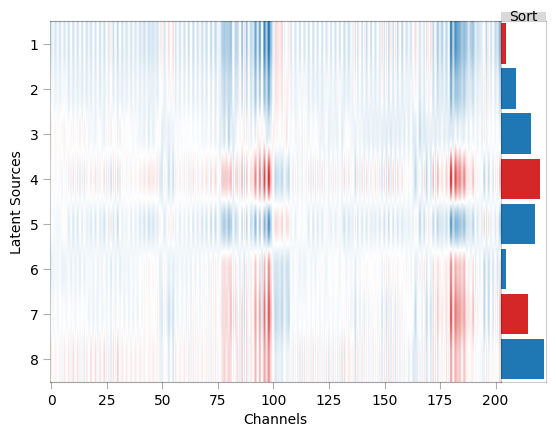

/tmp/ipykernel_6119/1135854246.py:530: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax24.set_xticklabels(times)


In [72]:
from collections.abc import Sequence
from typing import Callable
from matplotlib.widgets import Button
from collections.abc import Iterable
from functools import partial
import matplotlib as mpl
%matplotlib qt

import copy
import matplotlib as mpl

def plot_patterns(
    patterns: np.ndarray,
    info: mne.Info,
    order: int = None,
    axes: plt.Axes = None,
    cmap: str | mpl.colors.Colormap = 'RdBu_r',
    sensors: bool = True,
    colorbar: True = False,
    res: int = 64,
    size: int = 1,
    cbar_fmt: str = '%3.1f',
    name_format: str = 'Latent\nSource %01d',
    show: bool = True,
    show_names: bool = False,
    outlines: str = 'head',
    contours: int = 6,
    image_interp: str = 'linear'
) -> mpl.figure.Figure:
    """
    Plot spatial patterns for a group of sources.

    Args:
        patterns (numpy.ndarray): The source patterns to plot. The shape of the
            array should be (n_sources, n_channels).
        info (mne.Info): The measurement information.
        order (int, optional): The order in which to plot the patterns. If None,
            plot the patterns in the order in which they appear in the array.
            Defaults to None.
        axes (matplotlib.axes.Axes, optional): The matplotlib axes on which to
            plot the patterns. If None, create new axes. Defaults to None.
        cmap (str or matplotlib.colors.Colormap, optional): The colormap to use
            for the plot. Defaults to 'RdBu_r'.
        sensors (bool, optional): Whether to plot sensor locations. Defaults to
            True.
        colorbar (bool, optional): Whether to plot a colorbar. Defaults to False.
        res (int, optional): The resolution of the topomap. Defaults to 64.
        size (int, optional): The size of the plot. Defaults to 1.
        cbar_fmt (str, optional): The format string for colorbar tick labels.
            Defaults to '%3.1f'.
        name_format (str, optional): The format string for the title of each
            plot. Defaults to 'Latent\nSource %01d'.
        show (bool, optional): Whether to show the plot. Defaults to True.
        show_names (bool, optional): Whether to show the names of the channels.
            Defaults to False.
        outlines (str, optional): The name of the head outline to use. Defaults
            to 'head'.
        contours (int, optional): The number of contour lines to use. Defaults to 6.
        image_interp (str, optional): The interpolation method to use when
            plotting the topomap. Defaults to 'linear'.

    Returns:
        matplotlib.figure.Figure: The matplotlib figure containing the plot.
    """
    if order is None:
        order = range(patterns.shape[1])
    info = copy.deepcopy(info)
    info.__setstate__(dict(_unlocked=True))
    info['sfreq'] = 1.
    patterns = mne.EvokedArray(patterns, info, tmin=0)
    return patterns.plot_topomap(
        times=order,
        axes=axes,
        cmap=cmap, colorbar=colorbar, res=res,
        cbar_fmt=cbar_fmt, sensors=sensors, units=None, time_unit='s',
        time_format=name_format, size=size, show_names=show_names,
        outlines=outlines,
        contours=contours, image_interp=image_interp, show=show)


Limit = namedtuple('Limit', 'x y')

class SortingCallback:
    """
    Callback class for sorting data in an InterpretationPlotter object.

    Args:
        button (Button): The button object for triggering the callback.
        plotter (InterpretationPlotter): The InterpretationPlotter object containing the data to be sorted.
        fig (Figure): The matplotlib Figure object for displaying the data.
        indices (list[int]): The initial indices to use for sorting.

    Attributes:
        sorted_indices (list[int]): The sorted indices.

    Raises:
        AttributeError: If the sorted_indices attribute is attempted to be directly set.

    """

    def __init__(
        self,
        button: Button,
        plotter: 'InterpretationPlotter',
        fig: plt.Figure,
        indices: list[int]
    ):
        self._button = button
        self._plotter = plotter
        self._fig = fig
        self._bar_ax = self._plotter.main_axes[3]
        self._imshow_ax = self._plotter.main_axes[2]
        self._event = None
        self._sorted_indices = indices

    def __call__(self, event: mpl.backend_bases.MouseEvent):
        self._event = event

        if '▼' in self._button.label._text:
            self.decreasing()
        else:
            self.increasing()

    @property
    def sorted_indices(self):
        """
        The sorted indices.

        Returns:
            list[int]: The sorted indices.

        """
        return self._sorted_indices

    @sorted_indices.setter
    def sorted_indices(self, value):
        """
        Setter for the sorted_indices attribute. Raises an AttributeError if called.

        Args:
            value: The value to set the sorted_indices attribute to.

        Raises:
            AttributeError: Always raised, since the sorted_indices attribute cannot be directly set.

        """
        raise AttributeError('Impossible to set indices directly')

    def increasing(self):
        """
        Sort the data in increasing order and update the plot.

        """
        self._button.label.set_text('Sort ▼')
        self._sorted_indices = sorted(range(len(self._plotter.sums)), key=lambda k: self._plotter.sums[k], reverse=True)
        self.update()

    def decreasing(self):
        """
        Sort the data in decreasing order and update the plot.

        """
        self._button.label.set_text('Sort ▲')
        self._sorted_indices = sorted(range(len(self._plotter.sums)), key=lambda k: self._plotter.sums[k])
        self.update()

    def update(self):
        """
        Update the plot based on the sorted indices.

        """
        self._imshow_ax.clear()
        self._imshow_ax.imshow(self._plotter.params.spatial.patterns.T[self._sorted_indices, :], aspect='auto', cmap=self._plotter.cmap)
        self._plotter.main_axes[4].clear()
        temp_map = np.empty(self._plotter.params.spatial.patterns.T.shape)
        temp_map[:] = np.nan
        self._plotter.main_axes[4].imshow(temp_map, aspect='auto')
        self._bar_ax.clear()
        self._bar_ax.barh(
            range(len(self._plotter.sums)),
            np.abs(self._plotter.sums)[self._sorted_indices], color=self._plotter.colors[self._sorted_indices],
            height=.9
        )
        self._plotter.init_main_canvas(self)
        self._fig.canvas.draw()


class FilterButtonCallback:
    """
    Callback for a button that filters or resets filtering of temporal and induced data for a given cluster.

    Args:
        button (Button): The button widget.
        plotter (InterpretationPlotter): The plotter that shows the data.
        fig (plt.Figure): The figure that the plotter is drawn on.
        sorter (SortingCallback): The callback that sorts clusters.
        iy (int): The index of the cluster to filter.
        ax21 (plt.Axes): The first axes showing the induced data.
        ax22 (plt.Axes): The second axes showing the filtered induced data.
        ax22_t (plt.Axes): The second axes showing the time course of the cluster.
        ax23 (plt.Axes): The third axes showing the pattern of the cluster.
        ax24 (plt.Axes): The fourth axes showing the plot of the pattern on the topography.
        cb (mpl.colorbar.Colorbar): The colorbar that shows the color code of the induced data.
        shift (float): The shift parameter for the plot.
        f_max (int): The maximum frequency for induced data.
        crop (int): The number of samples to crop at the beginning and end of the data.
        legend (list[str]): The legend for the plot.
        filtered (bool): Whether the data is filtered or not.
    """
    def __init__(
        self,
        button: Button,
        plotter: 'InterpretationPlotter',
        fig: plt.Figure,
        sorter: SortingCallback,
        iy: int,
        ax21: plt.Axes,
        ax22: plt.Axes,
        ax22_t: plt.Axes,
        ax23: plt.Axes,
        ax24: plt.Axes,
        cb: mpl.colorbar.Colorbar,
        shift: float,
        f_max: int,
        crop: int,
        legend: list[str],
        filtered: bool = False,
    ):
        self.button = button
        self.plotter = plotter
        self.fig = fig
        self.sorter = sorter
        self.iy = iy
        self.axes = [ax21, ax22, ax22_t, ax23, ax24]
        self.cb = cb
        self.shift = shift
        self.f_max = f_max
        self.crop = crop
        self.legend = legend
        self.filtered = filtered,

    def __call__(self, event: mpl.backend_bases.MouseEvent):
        """
        Method that updates the figure when the button is clicked.

        Args:
            event (mpl.backend_bases.MouseEvent): The mouse click event.
        """
        self.filtered = not self.filtered
        text = 'Filter' if self.filtered else 'Redo'
        self.button.label.set_text(text)
        evoked = self.plotter.params.temporal.time_courses.mean(0)[self.sorter.sorted_indices[self.iy]][self.crop:-self.crop] if self.filtered else\
            self.plotter.params.temporal.time_courses_filtered.mean(0)[self.sorter.sorted_indices[self.iy]][self.crop:-self.crop]

        induced = self.plotter.params.temporal.induceds.copy()[
            self.sorter.sorted_indices[self.iy],
            :self.f_max,
            :
        ] if self.filtered else\
            self.plotter.params.temporal.induceds_filtered[
            self.sorter.sorted_indices[self.iy],
            :self.f_max,
            :
        ]
        induced = rowwise_zscore(induced)[:, self.crop:-self.crop]
        self.axes[1].axes.clear()
        self.axes[2].axes.clear()
        pos = self.axes[1].imshow(
            induced,
            origin='lower',
            cmap=self.plotter.cmap,
            interpolation='bicubic',
            aspect='auto',
            interpolation_stage='rgba',
        )
        self.axes[1].contour(
            induced,
            [
                np.percentile(induced, 25),
                np.percentile(induced, 75)
            ],
            origin='lower',
            linewidths=.1,
            cmap=self.plotter.cmap,
        )
        self.axes[2].plot(
            sp.stats.zscore(evoked),
            linewidth=.75
        )
        self.cb.remove()
        self.cb = self.fig.colorbar(
            pos,
            ax=self.axes[1],
            pad=0.12,
            orientation='horizontal',
            aspect=75,
            fraction=.12
        )
        self.plotter.init_additional_canvas(*self.axes, self.cb, self.shift, self.crop, self.legend)
        self.fig.canvas.draw()


# def rowwise_zscore(data: np.ndarray) -> np.ndarray:
#     out = np.zeros_like(data)

#     for i, row in enumerate(data):
#         out[i] = (row - row.mean())/row.std()

#     return out

def rowwise_zscore(data: np.ndarray) -> np.ndarray:
    """
    The rowwise_zscore function computes the z-score of each row of a given 2D array of numerical data.

    Args:
    data (np.ndarray): The input array of shape (m, n) where m is the number of rows and n is the number of columns.

    Returns:
    np.ndarray: An array of the same shape as the input data where each row has been standardized to have zero mean and unit variance.

    Raises:
    ValueError: If the input array has less than two dimensions.

    Example:
    >>> data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    >>> rowwise_zscore(data)
    array([[-1.22474487, 0. , 1.22474487],
    [-1.22474487, 0. , 1.22474487],
    [-1.22474487, 0. , 1.22474487]])
    """
    return (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)


class InterpretationPlotter:
    """
    A class for creating plots of the interpretations of the model's hidden units.

    Args:
        params (NetworkParameters): The network parameters to interpret.
        summarize (str | Sequence[int | float] | Callable[[np.ndarray], np.ndarray], optional):
            A method to summarize the spatial patterns. Defaults to 'sum'.

    Attributes:
        limits (Limit): The limit of the spatial patterns.
        info (dict): A dictionary containing information about the network parameters.
        params (NetworkParameters): The network parameters to interpret.
        sums (ndarray): The summarized spatial patterns.
        colors (ndarray): The colors used for the summary.
        main_fig (matplotlib.figure.Figure): The main figure object.
        main_axes (list[matplotlib.axes.Axes]): A list of the main axes objects.
        cmap (matplotlib.colors.ListedColormap): The colormap used for the plot.

    Methods:
        init_main_canvas(sorting_callback):
            Initializes the main canvas with the given sorting callback.
        init_additional_canvas(ax21, ax22, ax22_t, ax23, ax24, cb, shift, crop, legend):
            Initializes the additional canvas with the given parameters.
    """
    def __init__(
        self,
        params: NetworkParameters,
        summarize: str | Sequence[int | float] | Callable[[np.ndarray], np.ndarray] = 'sum',
    ):
        """
        Constructs an InterpretationPlotter.

        Args:
            params (NetworkParameters): The network parameters to interpret.
            summarize (str | Sequence[int | float] | Callable[[np.ndarray], np.ndarray], optional):
                A method to summarize the spatial patterns. Defaults to 'sum'.
        """
        self.limits = Limit(*params.spatial.patterns.shape)
        self.info = params.info
        self.params = params

        if summarize == 'sum':
            self.sums = np.sum(self.params.spatial.patterns, axis=0)
        elif summarize == 'sumabs':
            self.sums = np.sum(np.abs(self.params.spatial.patterns), axis=0)
        elif summarize == 'abssum':
            self.sums = np.abs(np.sum(self.params.spatial.patterns, axis=0))
        elif isinstance(summarize, Iterable) and len(summarize) == self.limits.y:
            self.sums = np.array(summarize)
        elif isinstance(summarize, Callable):
            self.sums = summarize(self.params.spatial.patterns)
        else:
            if isinstance(summarize, str):
                raise NotImplementedError(
                    f'The "{summarize}" method not implemented. '
                    'Available methods: "sum", "sumabs", "abssum"'
                )
            else:
                raise NotImplementedError(
                    f'The method for processing "{type(summarize)}" data for summary is not implemented. '
                )

        self.colors = np.array(['#d62728' if sum_ >= 0 else '#1f77b4' for sum_ in self.sums])
        self.main_fig = plt.figure()
        gs = self.main_fig.add_gridspec(2, 2, hspace=0, wspace=0, width_ratios=[1, .1], height_ratios=[.025, 1])
        # (ax01, ax02), (ax1, ax2)
        (ax0, ax1), (ax2, ax3) = gs.subplots(sharex='col', sharey='row')
        ax2_ = ax2.twinx()
        self.main_axes = [ax0, ax1, ax2, ax3, ax2_]
        self.cmap = generate_cmap(
            '#1f77b4',
            '#ffffff',
            '#d62728'
        )

    def init_main_canvas(self, sorting_callback: SortingCallback):
        """Initialize the main canvas for displaying the latent sources.

        Args:
            sorting_callback: An instance of the SortingCallback class, which
                provides access to the sorted indices of the latent sources.

        Returns:
            None
        """
        ax01, ax02, ax1, ax2, ax2_ = self.main_axes
        ax01.axes.xaxis.set_visible(False)
        ax01.axes.yaxis.set_visible(False)
        ax02.axes.xaxis.set_visible(False)
        ax02.axes.yaxis.set_visible(False)

        ax01.spines['right'].set_visible(False)
        ax01.spines['left'].set_visible(False)
        ax01.spines['top'].set_visible(False)
        ax01.spines['bottom'].set_visible(False)
        ax02.spines['right'].set_visible(False)
        ax02.spines['left'].set_visible(False)
        ax02.spines['top'].set_visible(False)
        ax02.spines['bottom'].set_visible(False)

        ax1.spines['right'].set_visible(False)
        ax1.set_xlabel('Channels')
        ax1.set_ylabel('Latent Sources')
        ax1.spines['left'].set_alpha(0.2)
        ax1.spines['bottom'].set_alpha(0.2)
        ax1.spines['top'].set_alpha(0.2)
        ax1.axes.yaxis.set_alpha(0.2)
        ax1.set_yticks(np.arange(self.limits.y))
        ax1.set_yticklabels(labels=[i + 1 for i in sorting_callback.sorted_indices])
        ax1.tick_params(axis='both', which='both', length=5, color='#00000050')

        ax2.axes.yaxis.set_visible(False)
        ax2.axes.xaxis.set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['top'].set_alpha(0.2)
        ax2.spines['right'].set_alpha(0.2)
        ax2.spines['bottom'].set_alpha(0.2)
        ax2_.axes.yaxis.set_visible(False)
        ax2_.spines['left'].set_visible(False)
        ax2_.axes.xaxis.set_visible(False)
        ax2_.spines['top'].set_alpha(0.2)
        ax2_.spines['right'].set_alpha(0.2)
        ax2_.spines['bottom'].set_alpha(0.2)

    def init_additional_canvas(
        self,
        ax21: plt.Axes,
        ax22: plt.Axes,
        ax22_t: plt.Axes,
        ax23: plt.Axes,
        ax24: plt.Axes,
        cb: mpl.colorbar.Colorbar,
        shift: float,
        crop: int,
        legend: list[str]
    ):
        """
        Initializes the additional canvas axes for the GUI.

        Args:
            ax21 (plt.Axes): The first axis.
            ax22 (plt.Axes): The second axis.
            ax22_t (plt.Axes): The third axis.
            ax23 (plt.Axes): The fourth axis.
            ax24 (plt.Axes): The fifth axis.
            cb (mpl.colorbar.Colorbar): The color bar.
            shift (float): The amount to shift the time axis.
            crop (int): The number of samples to crop from each side of the time axis.
            legend (list[str]): The legend to display on the fourth axis.

        Returns:
            None
        """
        ax22.set_aspect('auto')
        ax22_t.set_aspect('auto')
        ax22_t.set_ylabel('Amplitude (z-score)', labelpad=12.5, rotation=270)
        ax22_t.spines['top'].set_alpha(.2)
        ax22_t.spines['right'].set_alpha(.2)
        ax22_t.spines['left'].set_alpha(.2)
        ax22_t.spines['bottom'].set_alpha(.2)
        ax22_t.tick_params(axis='both', which='both', length=5, color='#00000050')
        ax22.spines['top'].set_alpha(.2)
        ax22.spines['right'].set_alpha(.2)
        ax22.spines['left'].set_alpha(.2)
        ax22.spines['bottom'].set_alpha(.2)
        ax22.tick_params(axis='both', which='both', length=5, color='#00000050')
        cb.outline.set_color('#00000020')
        cb.ax.tick_params(axis='both', which='both', length=5, color='#00000050')
        times = np.unique(np.round(self.params.temporal.times, 1))
        ranges = np.linspace(0, len(self.params.temporal.times), len(times)).astype(int)

        if shift is True:
            times = np.round(times - times.mean(), 2)
        elif isinstance(shift, (int, float)):
            times = np.round(times + shift, 2)

        ax22.set_xticks(ranges)
        ax22.set_xticklabels(times)
        ax22.set_xlabel('Time (s)')
        ax22.set_ylabel('Frequency (Hz)')
        ax23.legend(legend, loc='upper right')
        ax23.spines['top'].set_alpha(.2)
        ax23.spines['right'].set_alpha(.2)
        ax23.spines['left'].set_alpha(.2)
        ax23.spines['bottom'].set_alpha(.2)
        ax23.tick_params(axis='both', which='both', length=5, color='#00000050')
        ax23.set_xlabel('Frequency (Hz)')
        ax23.set_ylabel('Amplitude (z-score)')
        ax23.set_xlim([0, 70])
        ax22_t.set_xlim([2 * crop, len(self.params.temporal.times) - 2 * crop])

        ax24.spines['top'].set_alpha(.2)
        ax24.spines['right'].set_alpha(.2)
        ax24.spines['left'].set_alpha(.2)
        ax24.spines['bottom'].set_alpha(.2)
        ax24.set_xticklabels(times)
        ax24.set_xlabel('Time (s)')
        ax24.set_ylabel('Amplitude (z-score)')
        ax24.tick_params(axis='both', which='both', length=5, color='#00000050')

    def onclick(
        self,
        event: mpl.backend_bases.MouseEvent,
        sorting_callback: SortingCallback,
        spec_plot_elems: list[str],
        f_max: int = 70,
        timeshift: float = 0.,
        crop: float = 0.05
    ):
        """The onclick function performs various plotting operations when a mouse button is clicked over a figure.

        Args:
            event (mpl.backend_bases.MouseEvent): An object representing the event triggered by the click.
            sorting_callback (SortingCallback): An object that controls the sorting of neurons in the spatial patterns.
            spec_plot_elems (list[str]): A list of string names indicating which spectral data elements to plot.
            f_max (int, optional): The maximum frequency to plot in the induced activity plot. Default is 70.
            timeshift (float, optional): The amount of time by which to shift the temporal plots. Default is 0.
            crop (float, optional): The fraction of the total length of the temporal data to crop. Default is 0.05.

        Returns:
            None
        """

        self.main_axes[4].clear()

        _, iy = event.xdata, event.ydata

        if (event.inaxes == self.main_axes[2] or event.inaxes == self.main_axes[3] or event.inaxes == self.main_axes[4]) \
            and event.xdata is not None \
            and event.ydata is not None \
            and 0 < event.xdata < self.limits.x \
                and -.5 < event.ydata < self.limits.y:

            iy = int(np.rint(iy))

            if self.colors[sorting_callback._sorted_indices[iy]] == '#d62728':
                cmap = mpl.colors.ListedColormap(self.cmap.colors[::-1])
            else:
                cmap = self.cmap

            temp_map = np.empty(self.params.spatial.patterns.T.shape)
            temp_map[:] = np.nan
            temp_map[iy] = 1
            self.main_axes[4].imshow(temp_map, aspect='auto', cmap=cmap, alpha=.4)
            self.main_fig.canvas.draw()

            fig2 = plt.figure(constrained_layout=False)
            gs2 = fig2.add_gridspec(
                nrows=10,
                ncols=16,
                bottom=.1,
                wspace=.05,
                hspace=.1
            )

            ax21 = fig2.add_subplot(gs2[0:4, :-9])

            plot_patterns(
                self.params.spatial.patterns,
                info,
                sorting_callback.sorted_indices[iy],
                ax21,
                name_format='',
                cmap=self.cmap
            )

            ax22 = fig2.add_subplot(gs2[0:5, -7:])
            ax22_t = ax22.twinx()

            induced = params.temporal.induceds[sorting_callback.sorted_indices[iy]]

            induced_norm = rowwise_zscore(induced)

            crop = int(crop*induced.shape[1]/2)
            induced_norm = induced_norm[:f_max, crop:-crop]
            np.nan_to_num(induced_norm, copy=False)

            pos = ax22.imshow(
                induced_norm,
                origin='lower',
                cmap=self.cmap,
                interpolation='bicubic',
                aspect='auto',
                interpolation_stage='rgba',
            )

            ax22.contour(
                induced_norm,
                [
                    np.percentile(induced_norm, 25),
                    np.percentile(induced_norm, 75)
                ],
                origin='lower',
                linewidths=.1,
                cmap=self.cmap,
            )
            ax22_t.plot(
                sp.stats.zscore(self.params.temporal.time_courses.mean(0)[sorting_callback.sorted_indices[iy]][crop:-crop]),
                linewidth=.75
            )
            cb = fig2.colorbar(
                pos,
                ax=ax22,
                pad=0.12,
                orientation='horizontal',
                aspect=75,
                fraction=.12
            )

            ax23 = fig2.add_subplot(gs2[5:, -7:])
            spec_range = np.arange(0, self.params.spectral.range[-1], .1)
            interp_cubic = lambda y: sp.interpolate.interp1d(self.params.spectral.range, y, 'cubic')(spec_range)
            spec_legend = list()
            if 'input' in spec_plot_elems:
                spec_legend.append('input')
                data = sp.stats.zscore(np.real(self.params.spectral.inputs[sorting_callback.sorted_indices[iy]].mean(0)))
                data -= data.min()
                ax23.plot(
                    spec_range,
                    sp.stats.zscore(
                        interp_cubic(data)
                    ),
                    color='tab:blue',
                    alpha=.25
                )
            if 'output' in spec_plot_elems:
                spec_legend.append('output')
                data = sp.stats.zscore(np.real(self.params.spectral.outputs[sorting_callback.sorted_indices[iy]].mean(0)))
                data -= data.min()
                ax23.plot(
                    spec_range,
                    sp.stats.zscore(
                        interp_cubic(data)
                    ),
                    color='tab:blue',
                    linewidth=.75
                )
            if 'response' in spec_plot_elems:
                spec_legend.append('response')
                data = sp.stats.zscore(np.real(self.params.spectral.responses[sorting_callback.sorted_indices[iy]]))
                data -= data.min()
                ax23.plot(
                    spec_range,
                    interp_cubic(data),
                    alpha=.75,
                    linestyle='--',
                    color='tab:red'
                )
            if 'pattern' in spec_plot_elems:
                spec_legend.append('pattern')
                data = sp.stats.zscore(np.real(self.params.spectral.patterns[sorting_callback.sorted_indices[iy]].mean(0)))
                data -= data.min()
                ax23.plot(
                    spec_range,
                    sp.stats.zscore(
                        interp_cubic(data)
                    ),
                    color='tab:blue',
                    alpha=.75,
                    linestyle=':'
                )
            ax23.legend(spec_legend, loc='upper right')
            ax23.set_xlim(0, 100)

            ax24 = fig2.add_subplot(gs2[5:, :-9])
            times = self.params.temporal.times
            temp_legend = list()
            ax24.plot(
                times,
                sp.stats.zscore(
                    self.params.temporal.time_courses.mean(0)[sorting_callback.sorted_indices[iy]]
                ),
                linewidth=2, alpha=0.25
            )
            temp_legend.append('spatially filtered')
            ax24.plot(
                times,
                sp.stats.zscore(
                    self.params.temporal.time_courses_filtered.mean(0)[sorting_callback.sorted_indices[iy]]
                ),
                color='tab:blue',
                linewidth=1
            )
            temp_legend.append('temporally filtered')
            if self.params.temporal.patterns is not None:
                ax24.plot(
                    times,
                    sp.stats.zscore(
                        self.params.temporal.patterns[sorting_callback.sorted_indices[iy]],
                        color='tab:red',
                        linewidth=1.25,
                        linestyle='--',
                        alpha=.75
                    )
                )
                temp_legend.append('temporal pattern')
            ax24.legend(temp_legend, loc='upper right')
            self.init_additional_canvas(ax21, ax22, ax22_t, ax23, ax24, cb, timeshift, crop, spec_legend)

            axfilt = fig2.add_axes([0.86, 0.925, 0.04, 0.025])# posx, posy, width, height
            filt_button = Button(axfilt, 'Filter')
            axfilt._button = filt_button
            filt_callback = FilterButtonCallback(
                filt_button,
                self,
                fig2,
                sorting_callback,
                iy,
                ax21, ax22, ax22_t, ax23, ax24,
                cb,
                timeshift,
                f_max,
                crop,
                spec_legend
            )
            filt_button.on_clicked(filt_callback)

            plt.show()

    def plot(
        self,
        title: str = '',
        timeshift: float = 0.,
        f_max: float = 70,
        spec_plot_elems: list[str] = ['input', 'output', 'response'],
        show: bool = True
    ):
        """
        Plots the data on the main figure.

        Args:
            title (str, optional): Title of the plot. Defaults to ''.
            timeshift (float, optional): Shift in time for the plot. Defaults to 0..
            f_max (float, optional): Maximum frequency for the plot. Defaults to 70.
            spec_plot_elems (list[str], optional): List of plot elements to show. Defaults to ['input', 'output', 'response'].
            show (bool, optional): Whether to show the plot or not. Defaults to True.

        Returns:
            matplotlib.figure.Figure: The plotted figure.
        """
        sort_button = Button(self.main_axes[1], 'Sort')
        sorting_callback = SortingCallback(
            sort_button,
            self,
            self.main_fig,
            sorted(range(len(self.sums)), reverse=False)
        )
        self.init_main_canvas(sorting_callback)
        sort_button.on_clicked(sorting_callback)
        self.main_axes[2].imshow(self.params.spatial.patterns.T, aspect='auto', cmap=self.cmap)
        temp_map = np.empty(self.params.spatial.patterns.T.shape)
        temp_map[:] = np.nan
        self.main_axes[4].imshow(temp_map, aspect='auto')
        self.main_axes[3].barh(sorting_callback.sorted_indices, np.abs(self.sums), color=self.colors, height=.9)

        cid1 = self.main_fig.canvas.mpl_connect(
            'button_press_event',
            partial(
                self.onclick,
                sorting_callback=sorting_callback,
                spec_plot_elems=spec_plot_elems,
                f_max=f_max,
                timeshift=timeshift
            )
        )
        cid2 = self.main_fig.canvas.mpl_connect('close_event', lambda e: self.main_fig.canvas.mpl_disconnect(cid1))

        self.main_fig.canvas.mpl_disconnect(cid2)

        if show:
            plt.show()

        self.main_fig.suptitle(title)

        return self.main_fig


plotter = InterpretationPlotter(params, summarize=-params.order)
plotter.plot(timeshift=10.)

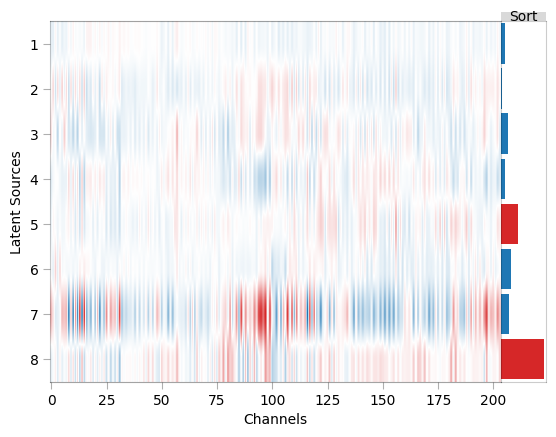

In [66]:
%matplotlib qt

plotter = InterpretationPlotter(info, params)
plotter.plot()

In [38]:


def plot_spatial_weights(
    spatial_parameters: SpatialParameters,
    temporal_parameters: TemporalParameters,
    waveforms: WaveForms,
    info: mne.Info,
    compressions: Optional[CompressionParameters] = None,
    summarize: Optional[Union[str, list[float]]] = 'sum',
    title: Optional[str] = 'Spatial Patterns',
    temp_params: Optional[list[str]] = ['input', 'response', 'output'],
    show: Optional[bool] = True,
    logscale: Optional[bool] = False,
    shift_induced_times: Optional[bool | float] = False
) -> Union[mp.figure.Figure, NoReturn]:

    mp.use('Qt5Agg')

    def init_canvas(ax01, ax02, ax1, ax2):
        ax01.axes.xaxis.set_visible(False)
        ax01.axes.yaxis.set_visible(False)
        ax02.axes.xaxis.set_visible(False)
        ax02.axes.yaxis.set_visible(False)

        ax01.spines['right'].set_visible(False)
        ax01.spines['left'].set_visible(False)
        ax01.spines['top'].set_visible(False)
        ax01.spines['bottom'].set_visible(False)
        ax02.spines['right'].set_visible(False)
        ax02.spines['left'].set_visible(False)
        ax02.spines['top'].set_visible(False)
        ax02.spines['bottom'].set_visible(False)

        ax1.spines['right'].set_visible(False)
        ax1.set_xlabel('Channels')
        ax1.set_ylabel('Latent Sources')
        ax1.spines['left'].set_alpha(0.2)
        ax1.spines['bottom'].set_alpha(0.2)
        ax1.spines['top'].set_alpha(0.2)
        ax1.axes.yaxis.set_alpha(0.2)
        ax1.set_yticks(np.arange(y_lim))
        ax1.set_yticklabels(labels=[i + 1 for i in sorting_callback.sorted_indices])
        ax1.tick_params(axis='both', which='both', length=5, color='#00000050')

        ax2.axes.yaxis.set_visible(False)
        ax2.axes.xaxis.set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['top'].set_alpha(0.2)
        ax2.spines['right'].set_alpha(0.2)
        ax2.spines['bottom'].set_alpha(0.2)

    class SortingCallback:

        def __init__(
            self,
            button: Button,
            fig: plt.Figure,
            bar_ax: mpl.axes.Axes,
            imshow_ax: mpl.axes.Axes,
            indices: list[int]
        ):
            self._button = button
            self._fig = fig
            self._bar_ax = bar_ax
            self._imshow_ax = imshow_ax
            self._event = None
            self._sorted_indices = indices

        def __call__(self, event):
            self._event = event

            if '▼' in self._button.label._text:
                self.decreasing()
            else:
                self.increasing()

        @property
        def sorted_indices(self):
            return self._sorted_indices

        @sorted_indices.setter
        def sorted_indices(self, value):
            raise AttributeError('Impossible to set indices directly')

        def increasing(self):
            self._button.label.set_text('Sort ▼')
            self._sorted_indices = sorted(range(len(sums)), key=lambda k: sums[k], reverse=True)
            self.update()

        def decreasing(self):
            self._button.label.set_text('Sort ▲')
            self._sorted_indices = sorted(range(len(sums)), key=lambda k: sums[k])
            self.update()

        def update(self):
            self._imshow_ax.clear()
            self._imshow_ax.imshow(data.T[self._sorted_indices, :], aspect='auto', cmap='RdBu_r')
            self._bar_ax.clear()
            self._bar_ax.barh(
                range(len(sums)),
                np.abs(sums)[self._sorted_indices], color=colors[self._sorted_indices],
                height=.9
            )
            init_canvas(ax01, ax02, ax1, ax2)
            self._fig.canvas.draw()

    def onclick(event):
        flim = 70
        crop = .05
        shift = shift_induced_times

        if ax1.lines:

            for i in range(len(ax1.lines)):
                ax1.lines.remove(ax1.lines[i])

        _, iy = event.xdata, event.ydata

        if (event.inaxes == ax1 or event.inaxes == ax2) \
            and event.xdata is not None \
            and event.ydata is not None \
            and 0 < event.xdata < x_lim \
                and -.5 < event.ydata < y_lim:
            iy = int(np.rint(iy))
            induced = waveforms.induced.copy()[
                sorting_callback.sorted_indices[iy],
                :flim,
                :
            ]
            crop *= induced.shape[1] / 2

            for i, ind_course in enumerate(induced):
                induced[i] /= ind_course.mean()

            color = colors[sorting_callback._sorted_indices[iy]]
            line = mp.lines.Line2D([0, x_lim], [iy, iy], color=color, linewidth=2.56*data.shape[0]/data.shape[1], alpha=.4)
            ax1.add_line(line)
            fig1.canvas.draw()
            fig2 = plt.figure(constrained_layout=False)
            if compressions is None:
                gs2 = fig2.add_gridspec(
                    nrows=10,
                    ncols=3,
                    bottom=.1,
                    wspace=.05,
                    hspace=.1
                )
                ax21 = fig2.add_subplot(gs2[:, :-1])
                ax22 = fig2.add_subplot(gs2[0:5, -1])
                ax23 = fig2.add_subplot(gs2[5:, -1])
            else:
                gs2 = fig2.add_gridspec(
                    nrows=10,
                    ncols=16,
                    bottom=.1,
                    wspace=.05,
                    hspace=.1
                )
                ax21 = fig2.add_subplot(gs2[0:4, :-8])
                ax22 = fig2.add_subplot(gs2[0:5, -7:])
                ax23 = fig2.add_subplot(gs2[5:, -7:])
                ax24 = fig2.add_subplot(gs2[5:, :-9])

            plot_patterns(
                data,
                info,
                sorting_callback.sorted_indices[iy],
                ax21,
                name_format=''
            )
            ax22_t = ax22.twinx()
            evoked = waveforms.evoked[sorting_callback.sorted_indices[iy]]
            ax22_t.plot(
                sp.stats.zscore(evoked),
                '#454545'
            )
            pos = ax22.imshow(
                induced,
                cmap='RdBu_r',
                origin='lower'
            )
            cb = fig2.colorbar(
                pos,
                ax=ax22,
                pad=0.12,
                orientation='horizontal',
                aspect=75,
                fraction=.12
            )

            # ax22_t.set_ylim(top=1, bottom=-1)
            legend = list()
            for param in temp_params:
                match param:
                    case 'input':
                        legend.append('Filter input')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.finputs[sorting_callback.sorted_indices[iy]]),
                            color='tab:blue'
                        )
                    case 'output':
                        legend.append('Filter output')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(temporal_parameters.foutputs[sorting_callback.sorted_indices[iy]]),
                            color='tab:orange'
                        )
                    case 'response':
                        legend.append('Filter response')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(
                                temporal_parameters.fresponces[sorting_callback.sorted_indices[iy]]
                            ),
                            color='tab:green'
                        )
                    case 'pattern':
                        legend.append('Filtering pattern')
                        ax23.plot(
                            temporal_parameters.franges,
                            sp.stats.zscore(
                                temporal_parameters.fpatterns[sorting_callback.sorted_indices[iy]]
                            ),
                            color='tab:pink'
                        )
                    case _:
                        raise NotImplementedError(f'Temporal parameter {param} is not implemented')

            if compressions:
                evo = sp.stats.zscore(waveforms.evoked_filt[sorting_callback.sorted_indices[iy]])
                ax24.plot(
                    evo# - evo.min()
                )
                loss_estimate = sp.stats.zscore(compressions.loss_estimate[sorting_callback.sorted_indices[iy]])
                kernel_size = 20
                loss_estimate = moving_average(loss_estimate - loss_estimate.min())
                # loss_estimate[kernel_size//2:-kernel_size//2] = loss_estimate[kernel_size//2:-kernel_size//2] - loss_estimate[kernel_size//2:-kernel_size//2].min()
                ax24.plot(
                    loss_estimate
                )

            def init_canvas2(cb):
                ax22.set_aspect('auto')
                ax22_t.set_aspect('auto')
                ax22_t.set_ylabel('Amplitude', labelpad=12.5, rotation=270)
                ax22_t.spines['top'].set_alpha(.2)
                ax22_t.spines['right'].set_alpha(.2)
                ax22_t.spines['left'].set_alpha(.2)
                ax22_t.spines['bottom'].set_alpha(.2)
                ax22_t.tick_params(axis='both', which='both', length=5, color='#00000050')
                ax22.spines['top'].set_alpha(.2)
                ax22.spines['right'].set_alpha(.2)
                ax22.spines['left'].set_alpha(.2)
                ax22.spines['bottom'].set_alpha(.2)
                ax22.tick_params(axis='both', which='both', length=5, color='#00000050')
                cb.outline.set_color('#00000020')
                cb.ax.tick_params(axis='both', which='both', length=5, color='#00000050')
                times = np.unique(np.round(waveforms.times, 1))
                ranges = np.linspace(0, len(waveforms.times), len(times)).astype(int)

                if shift is True:
                    times = np.round(times - times.mean(), 2)
                elif isinstance(shift, (int, float)):
                    times = np.round(times - shift, 2)

                ax22.set_xticks(ranges)
                ax22.set_xticklabels(times)
                ax22.set_xlabel('Time (s)')
                ax22.set_ylabel('Frequency (Hz)')
                ax23.legend(legend, loc='upper right')
                ax23.spines['top'].set_alpha(.2)
                ax23.spines['right'].set_alpha(.2)
                ax23.spines['left'].set_alpha(.2)
                ax23.spines['bottom'].set_alpha(.2)
                ax23.tick_params(axis='both', which='both', length=5, color='#00000050')
                ax23.set_xlabel('Frequency (Hz)')
                ax23.set_ylabel('Amplitude (z-score)')
                # ax23.set_ylim(top=1.2)
                ax23.set_xlim([0, 70])
                ax22_t.set_xlim([2 * crop, len(waveforms.times) - 2 * crop])

                if logscale:
                    ax23.set_yscale('log')

                if compressions:
                    ax24.spines['top'].set_alpha(.2)
                    ax24.spines['right'].set_alpha(.2)
                    ax24.spines['left'].set_alpha(.2)
                    ax24.spines['bottom'].set_alpha(.2)
                    ax24.set_xticks(ranges)
                    ax24.set_xticklabels(times)
                    ax24.set_xlabel('Time (s)')
                    ax24.set_ylabel('Amplitude (z-score)')
                    ax24.tick_params(axis='both', which='both', length=5, color='#00000050')
                    ax24.legend(
                        [
                            'Filtered component evoked',
                            'Loss-based estimate'
                        ],
                        loc='upper right'
                    )

            init_canvas2(cb)

            fig2.suptitle(f'Latent source {sorting_callback.sorted_indices[iy] + 1}')

            class FilterButtonCallback:
                def __init__(self, button, filtered_induced, cb):
                    self.button = button
                    self.filtered = filtered_induced
                    self.cb = cb
                def __call__(self, event):
                    self.filtered = not self.filtered
                    text = 'Filter' if not self.filtered else 'Redo'
                    self.button.label.set_text(text)
                    evoked = waveforms.evoked[sorting_callback.sorted_indices[iy]] if not self.filtered else\
                        waveforms.evoked_filt[sorting_callback.sorted_indices[iy]]
                    induced = waveforms.induced.copy()[
                        sorting_callback.sorted_indices[iy],
                        :flim,
                        :
                    ] if not self.filtered else\
                        waveforms.induced_filt.copy()[
                        sorting_callback.sorted_indices[iy],
                        :flim,
                        :
                    ]
                    for i, ind_course in enumerate(induced):
                        induced[i] /= ind_course.mean()
                    ax22_t.axes.clear()
                    ax22_t.plot(
                        sp.stats.zscore(evoked),
                        '#454545'
                    )
                    ax22.axes.clear()
                    pos = ax22.imshow(
                        induced,
                        cmap='RdBu_r',
                        origin='lower'
                    )
                    self.cb.remove()
                    self.cb = fig2.colorbar(
                        pos,
                        ax=ax22,
                        pad=0.12,
                        orientation='horizontal',
                        aspect=75,
                        fraction=.12
                    )
                    init_canvas2(self.cb)
                    fig2.canvas.draw()

            axfilt = fig2.add_axes([0.86, 0.925, 0.04, 0.025])#posx, posy, width, height
            filt_button = Button(axfilt, 'Filter')
            axfilt._button = filt_button
            filt_callback = FilterButtonCallback(filt_button, False, cb)
            filt_button.on_clicked(filt_callback)

            plt.show()

    data = spatial_parameters.patterns.copy()
    x_lim, y_lim = data.shape
    fig1 = plt.figure()
    fig1.suptitle(title)
    gs = fig1.add_gridspec(2, 2, hspace=0, wspace=0, width_ratios=[1, .1], height_ratios=[.025, 1])

    (ax01, ax02), (ax1, ax2) = gs.subplots(sharex='col', sharey='row')

    if summarize == 'sum':
        sums = np.sum(data, axis=0)
    elif summarize == 'sumabs':
        sums = np.sum(np.abs(data), axis=0)
    elif summarize == 'abssum':
        sums = np.abs(np.sum(data, axis=0))
    elif isinstance(summarize, Iterable) and len(summarize) == y_lim:
        sums = np.array(summarize)
    else:
        raise NotImplementedError(
            f'The "{summarize}" method not implemented. '
            'Available methods: "sum", "sumabs", "abssum"'
        )
    colors = np.array(['#f2827a' if sum_ >= 0 else '#8bbae5' for sum_ in sums])

    sort_button = Button(ax02, 'Sort')
    sorting_callback = SortingCallback(
        sort_button,
        fig1,
        ax2,
        ax1,
        sorted(range(len(sums)), reverse=False)
    )
    sort_button.on_clicked(sorting_callback)

    init_canvas(ax01, ax02, ax1, ax2)

    ax1.imshow(data.T, aspect='auto', cmap='RdBu_r')
    ax2.barh(sorting_callback.sorted_indices, np.abs(sums), color=colors, height=.9)

    cid1 = fig1.canvas.mpl_connect('button_press_event', onclick)
    cid2 = fig1.canvas.mpl_connect('close_event', lambda e: fig1.canvas.mpl_disconnect(cid1))

    if show:
        plt.show()

    fig1.canvas.mpl_disconnect(cid2)

    return fig1

NameError: name 'WaveForms' is not defined